In [ ]:
from core.database import engine
from sqlmodel import text
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.svm import SVC
import numpy as np
import networkx as nx

In [77]:
similarity_query = """
-- Encontrar pares de itens duplicados com mesma marca e embedding similar
SELECT 
    a.id as item_1_id,
    b.id as item_2_id,
    a.name as item_1_name,
    b.name as item_2_name,
    a.brand_name as brand,
    a.description as item_1_description,
    b.description as item_2_description,
    a.price as price_1,
    b.price as price_2,
    similarity(a.name, b.name) as similarity_gram_name,
    similarity(a.description , b.description) as similarity_gram_description,
    1 - (a.name_description_embedding <=> b.name_description_embedding) as similarity_embedding
FROM raw_item a
INNER JOIN raw_item b 
    ON (a.price BETWEEN b.price * 0.7 AND b.price * 1.3)
    AND a.id < b.id  -- Evita duplicatas (A-B e B-A) e auto-match
WHERE 
    a.name_description_embedding IS NOT NULL 
    AND b.name_description_embedding IS NOT null
    AND a."name" IS NOT NULL 
    AND b."name" IS NOT null
    AND 1 - (a.name_description_embedding <=> b.name_description_embedding) >= 0.7
    
ORDER BY 
    similarity_embedding DESC,
    similarity_gram_name DESC,
    a.brand_name,
    a.id;"""

In [78]:
with engine.connect() as conn:
    result = conn.execute(text(similarity_query))
    df_pairs = result.fetchall()

In [79]:
X = pd.DataFrame(df_pairs)

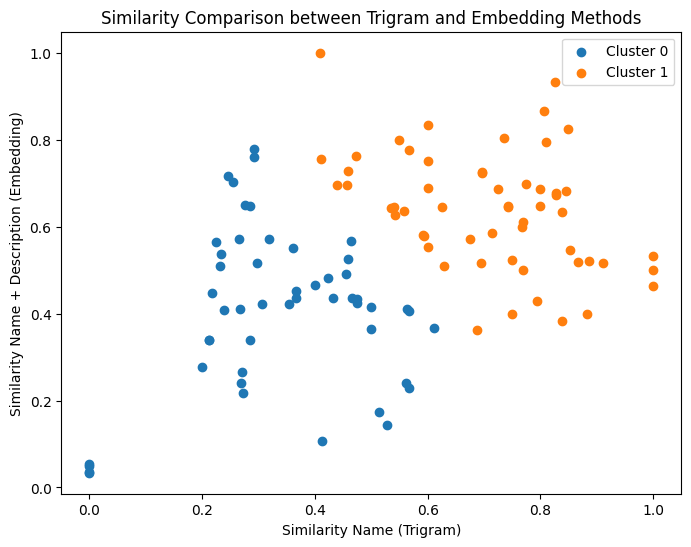

In [80]:
kmeans = KMeans(n_clusters=2, random_state=40)
X['cluster'] = kmeans.fit_predict(X[['similarity_gram_name', 'similarity_gram_description']])


# Scatter plot com cores por cluster
plt.figure(figsize=(8,6))
for cluster in X['cluster'].unique():
    subset = X[X['cluster'] == cluster]
    plt.scatter(
        subset['similarity_gram_name'],
        subset['similarity_gram_description'],
        label=f'Cluster {cluster}'
    )

plt.xlabel("Similarity Name (Trigram)")
plt.ylabel("Similarity Name + Description (Embedding)")
plt.title("Similarity Comparison between Trigram and Embedding Methods")
plt.legend()
plt.show()


In [81]:
X.cluster.value_counts()

cluster
1    56
0    50
Name: count, dtype: int64

In [82]:
y = (X['cluster'] == 0).astype(int).values
X_matrix = X[['similarity_gram_name','similarity_gram_description']].values

In [83]:
svm = SVC(kernel='linear', probability=True)
svm = svm.fit(X_matrix, y)
X['predicted_cluster'] = svm.predict_proba(X_matrix).round(2)[:,0] >= 0.5

In [84]:
w = svm.coef_[0]      # vetor normal ao plano
b = svm.intercept_[0] # intercepto

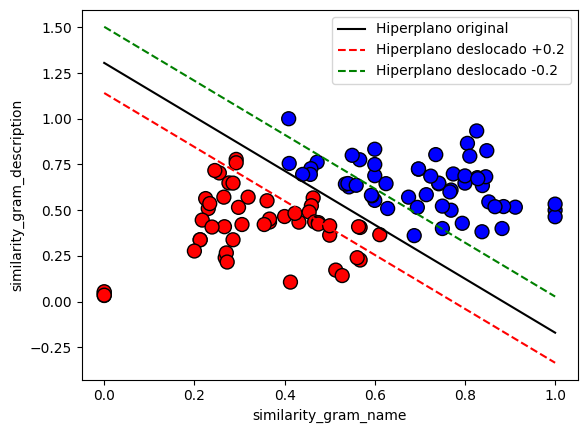

In [100]:

# offset que você quer aplicar
d = 0.2  # positivo ou negativo

# Função para calcular x2 em função de x1
def hyperplane(x1, w, b, d=0):
    return -(w[0]*x1 + b + d)/w[1]

# Plotando
x1_vals = np.linspace(0, 1, 100)

# Hiperplano original
x2_orig = hyperplane(x1_vals, w, b, d=0)
# Hiperplano deslocado (offset positivo)
x2_shift = hyperplane(x1_vals, w, b, d=-0.5)
# Hiperplano deslocado (offset negativo)
x2_shift_neg = hyperplane(x1_vals, w, b, d=0.6)

plt.scatter(X_matrix[:,0], X_matrix[:,1], c=y, s=100, cmap='bwr', edgecolors='k')
plt.plot(x1_vals, x2_orig, 'k-', label='Hiperplano original')
plt.plot(x1_vals, x2_shift, 'r--', label='Hiperplano deslocado +0.2')
plt.plot(x1_vals, x2_shift_neg, 'g--', label='Hiperplano deslocado -0.2')
plt.xlabel('similarity_gram_name')
plt.ylabel('similarity_gram_description')
plt.legend()
plt.show()

In [101]:
d=0
pred_shift = (np.sign(np.dot(X_matrix, w) + b + d) > 0).astype(int)

In [92]:
pd.Series(pred_shift).value_counts()

0    56
1    50
Name: count, dtype: int64

In [93]:
X['pred_cluster'] = pred_shift

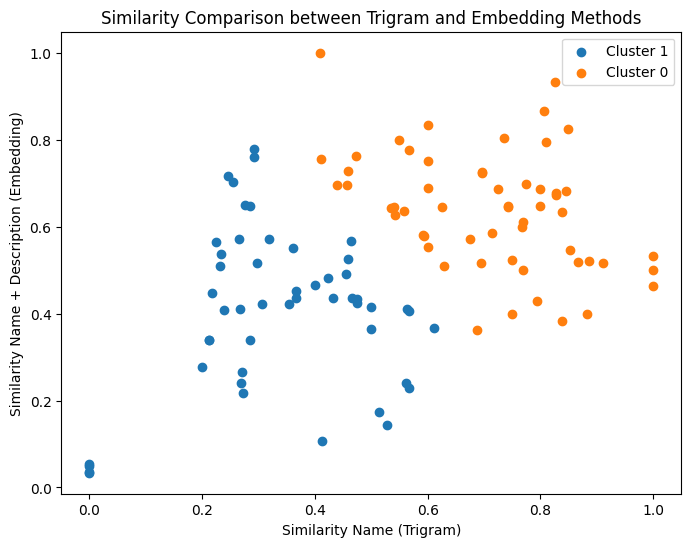

In [94]:
# Scatter plot com cores por cluster
plt.figure(figsize=(8,6))
for cluster in X['pred_cluster'].unique():
    subset = X[X['pred_cluster'] == cluster]
    plt.scatter(
        subset['similarity_gram_name'],
        subset['similarity_gram_description'],
        label=f'Cluster {cluster}'
    )

plt.xlabel("Similarity Name (Trigram)")
plt.ylabel("Similarity Name + Description (Embedding)")
plt.title("Similarity Comparison between Trigram and Embedding Methods")
plt.legend()
plt.show()


In [103]:
X[X['pred_cluster'] == 0]

,item_1_id,item_2_id,item_1_name,item_2_name,brand,item_1_description,item_2_description,price_1,price_2,similarity_gram_name,similarity_gram_description,similarity_embedding,cluster,predicted_cluster,pred_cluster
4,28,78,SSD 500GB Kingston,SSD Kingston 500GB SATA,Kingston,"SSD SATA III 500GB 2.5"" leitura 550MB/s escrit...","SATA III 2.5"" 500GB leitura 550MB/s escrita 52...",250.00,245.00,0.826087,0.933333,0.983486,1,True,0
5,49,99,Impressora Canon PIXMA G3010,Impressora Canon PIXMA G3010 Tanque,Canon,Impressora tanque de tinta colorida scanner Wi-Fi,Tanque de tinta colorida scanner Wi-Fi impressão,950.00,945.00,0.805556,0.865385,0.971968,1,True,0
6,50,100,Mesa Escritório com Gaveta 120cm,Mesa Escritório c/ Gaveta 120cm,Allma,Mesa escritório com gaveta MDF 120x60cm branca,Com gaveta MDF branca 120cm largura 60cm profu...,520.00,515.00,0.882353,0.400000,0.945172,1,True,0
7,3,53,Papel A4 500 folhas branco,Papel A4 500fls branco 75g,Chamex,Papel sulfite branco 500 folhas 75g/m²,Sulfite A4 branco 500 folhas gramatura 75g/m²,25.50,24.90,0.542857,0.627451,0.943406,1,True,0
8,9,59,Teclado Logitech USB,Teclado USB Logitech ABNT2,Logitech,Teclado USB padrão ABNT2 português,USB padrão brasileiro ABNT2 português layout,95.00,92.50,0.769231,0.500000,0.939163,1,True,0
10,27,77,Webcam Logitech C920 HD,Webcam Logitech C920 Full HD,Logitech,Webcam Full HD 1080p 30fps com microfone integ...,Full HD 1080p 30fps microfone estéreo integrado,450.00,445.00,0.827586,0.677966,0.935153,1,True,0
11,48,98,Monitor Asus VG248QE 24 polegadas,"Monitor Asus VG248QE 24"" 144Hz",Asus,"Monitor LED 24"" Full HD 144Hz 1ms gaming","LED 24"" Full HD 144Hz 1ms resposta gaming Free...",1200.00,1195.00,0.600000,0.553571,0.931213,1,True,0
12,42,92,HD Externo 2TB Western Digital,HD Externo WD 2TB USB 3.0,Western Digital,HD externo USB 3.0 2TB portátil preto,Externo portátil USB 3.0 2TB preto compacto,520.00,515.00,0.410256,0.755556,0.930836,1,True,0
13,68,69,Caneta BIC Preta média,Caneta BIC Vermelha média,BIC,Esferográfica preta ponta média corpo transpar...,Esferográfica vermelha ponta média corpo trans...,2.45,2.45,0.566667,0.775862,0.930757,1,True,0
14,46,96,Carregador Rápido 33W Xiaomi,Carregador Rápido Xiaomi 33W USB-C,Xiaomi,Carregador rápido USB-C 33W com cabo,Rápido USB-C 33W com cabo 1m compatível,65.00,62.90,0.852941,0.545455,0.930673,1,True,0


In [104]:
df_pairs

[(1, 17, 'Sample Item', 'Papel A4 500 folhas reciclado', 'Sample Brand', 'This is a sample item.', 'Papel sulfite reciclado 500 folhas 75g/m²', Decimal('19.99'), Decimal('22.90'), 0.0, 0.033898305, nan),
 (1, 53, 'Sample Item', 'Papel A4 500fls branco 75g', 'Sample Brand', 'This is a sample item.', 'Sulfite A4 branco 500 folhas gramatura 75g/m²', Decimal('19.99'), Decimal('24.90'), 0.0, 0.048387095, nan),
 (1, 67, 'Sample Item', 'Papel A4 500 folhas reciclado Chamex', 'Sample Brand', 'This is a sample item.', 'Sulfite reciclado A4 500 folhas 75g/m²', Decimal('19.99'), Decimal('22.50'), 0.0, 0.054545455, nan),
 (1, 3, 'Sample Item', 'Papel A4 500 folhas branco', 'Sample Brand', 'This is a sample item.', 'Papel sulfite branco 500 folhas 75g/m²', Decimal('19.99'), Decimal('25.50'), 0.0, 0.035714287, nan),
 (28, 78, 'SSD 500GB Kingston', 'SSD Kingston 500GB SATA', 'Kingston', 'SSD SATA III 500GB 2.5" leitura 550MB/s escrita 520MB/s', 'SATA III 2.5" 500GB leitura 550MB/s escrita 520MB/s', D

In [ ]:
import networkx as nx

G = nx.Graph()

edges = df_pairs[df_pairs["match_probability"] >= 0.9][
    ["id_l", "id_r"]
].values

G.add_edges_from(edges)

clusters = list(nx.connected_components(G))

cluster_map = {
    node: cluster_id
    for cluster_id, nodes in enumerate(clusters)
    for node in nodes
}